In [1]:
import pandas as pd
import numpy as np
import chess.pgn
import chess

Download & unzip a file from here

https://database.lichess.org/

In [2]:
pgn = open("lichess_db_standard_rated_2018-10.pgn")

In [3]:
g = chess.pgn.read_game(pgn)

In [4]:
g.headers["Result"]

'1-0'

In [5]:
board = g.board()


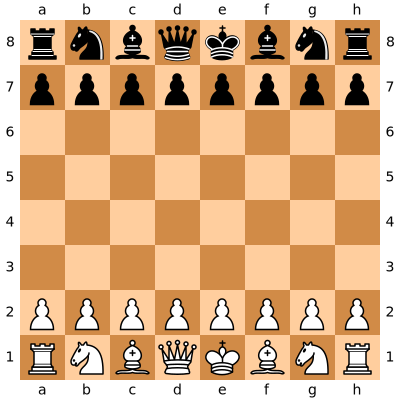

In [6]:
board

In [7]:
import re

increase/decrease the number of samples by changing the range of the for loop

In [9]:
%%time
moves = []

for i in range(10000):
    g = chess.pgn.read_game(pgn)
    board = chess.Board()
    for move in g.mainline_moves():
        board.push(move)
        s = board.fen()
        list(s)
        s = re.sub(r'\s.*$','',s)
        s = re.sub(r'8','11111111',s)
        s = re.sub(r'7','1111111',s)
        s = re.sub(r'6','111111',s)
        s = re.sub(r'5','11111',s)
        s = re.sub(r'4','1111',s)
        s = re.sub(r'3','111',s)
        s = re.sub(r'2','11',s)
        s = s.split('/')
        s = [list(i) for i in s]
#         t = re.sub(r'r','2',s)
#         u = re.sub(r'R','3',t)
#         v = re.sub(r'n','4',u)
#         w = re.sub(r'N','5',v)
#         x = re.sub(r'b','6',w)
#         y = re.sub(r'B','7',x)
#         z = re.sub(r'q','8',y)
#         a = re.sub(r'Q','9',z)
#         b = re.sub(r'k','10',a)
#         c = re.sub(r'K','11',b)
#         d = re.sub(r'p','12',c)
#         e = re.sub(r'P','13',d)
        


        moves.append((s,g.headers["WhiteElo"],g.headers["BlackElo"],g.headers["Result"]))

Wall time: 1min 17s


Put everything in a dataframe. 

Fix results to be in the perspective of white.

In [10]:
df = pd.DataFrame(moves,columns=["fen_list","white_elo","black_elo","result"])
df["result"] =df["result"].replace("1-0",1.0)
df["result"] =df["result"].replace("0-1",0.0)
df["result"] =df["result"].replace("1/2-1/2",0.5)
targets = df[["white_elo","black_elo","result"]]

Convert fen_list to a np.array()

In [11]:
import numpy as np

In [12]:
fen = np.vstack(df["fen_list"])

In [13]:
l = len(moves)

reshape the fen to a shape of 8,8 (board size) and the number of samples

In [15]:
fen = fen.reshape(l,8,8)
fen = fen[:100000]
targets =df["result"][:100000]

In [16]:
fen.shape

(100000, 8, 8)

# vectorize

convert 1 to 0 and all letter to numbers.
This is in order to work with the to_categorical function

In [17]:
fen[fen=='1'] = 0
fen[fen=='r'] = 1
fen[fen=='R'] = 2
fen[fen=='n'] = 3
fen[fen=='N'] = 4
fen[fen=='b'] = 5
fen[fen=='B'] = 6
fen[fen=='q'] = 7
fen[fen=='Q'] = 8
fen[fen=='k'] = 9
fen[fen=='K'] = 10
fen[fen=='p'] = 11
fen[fen=='P'] = 12

In [18]:
import keras

Using TensorFlow backend.


In [19]:
from keras.utils import to_categorical
from keras.utils import np_utils
encoded_fen = np_utils.to_categorical(fen,13,)

In [20]:
encoded_fen.shape

(100000, 8, 8, 13)

In [21]:
from keras.models import Sequential
from keras import layers

Structure, compile, train and validate the training of the model.

In [22]:
!pip install tensorflowjs

^C


In [23]:
import os

In [25]:
model = Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',
                        input_shape=(8,8,13)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics =['acc'])
blackbox = model.fit(encoded_fen, targets, epochs= 10, batch_size = 64, validation_split=0.2)


Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 11s 135us/step - loss: 0.6208 - acc: 0.6095 - val_loss: 0.7762 - val_acc: 0.5052
Epoch 2/10
80000/80000 [==============================] - 4s 44us/step - loss: 0.4846 - acc: 0.7238 - val_loss: 0.9271 - val_acc: 0.4925
Epoch 3/10
80000/80000 [==============================] - 3s 44us/step - loss: 0.3737 - acc: 0.7904 - val_loss: 1.0320 - val_acc: 0.4978
Epoch 4/10
80000/80000 [==============================] - 3s 44us/step - loss: 0.2928 - acc: 0.8332 - val_loss: 1.1464 - val_acc: 0.4868
Epoch 5/10
80000/80000 [==============================] - 4s 44us/step - loss: 0.2421 - acc: 0.8561 - val_loss: 1.3224 - val_acc: 0.4950
Epoch 6/10
80000/80000 [==============================] - 4s 44us/step - loss: 0.2094 - acc: 0.8713 - val_loss: 1.3716 - val_acc: 0.5017
Epoch 7/10
80000/80000 [==============================] - 4s 44us/step - loss: 0.1873 - acc: 0.8806 - val_loss: 1.5940 - val_a

In [ ]:
tfjs.converters.save_keras_model(model, os.path)